<a href="https://colab.research.google.com/github/YoheiFukuhara/keras-for-beginner/blob/master/Keras10_image_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[「KerasのImageDataGeneratorを使いつつ複数Input統合モデル」](https://qiita.com/FukuharaYohei/items/ccb61919e89361bbe9bd)参照

In [0]:
from random import random
from math import ceil

import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, concatenate, Dense, Conv2D, MaxPooling2D, Flatten, SimpleRNN
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image 
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.utils.vis_utils import plot_model
import numpy as np

In [0]:
NUM_DATA = 4 # Number of data

x_image = np.random.rand(NUM_DATA, 16, 16, 1) # dummy gray scale image as random value
x_text  = np.random.randint(0, 10, (NUM_DATA, 3, 1)) # dummy text
y_train = np.arange(NUM_DATA).reshape(NUM_DATA, 1)  # dummy label
y_train = np_utils.to_categorical(y_train) # to one hot-encoding

In [0]:
# Generator for 2 input
def gen_flow_for_two_inputs(datagen, batch, x_image, x_text, y_train, shuffle=True):
    
    # Create index
    x_index = np.arange(x_image.shape[0])
    
    # Pass index to the 2nd parameter instead of labels
    batch = datagen.flow(x_image, x_index, batch_size=batch, shuffle=shuffle)
    while True:
        batch_image, batch_index = batch.next()
        
        # Use index values for text(x_text) and labels(y_train)
        yield [batch_image, x_text[batch_index]], y_train[batch_index]

In [11]:
sample_datagen = image.ImageDataGenerator() # data generator for checking generator
gen_flow = gen_flow_for_two_inputs(sample_datagen, 2, x_image, x_text, y_train, False)

# check generator
for i, batch in enumerate(gen_flow):
    print(i, '-----')
    print(batch[0][0].shape)
    print(batch[0][1].shape)
    print(batch[1].shape)
    print(batch[1])
    if i == 1:
        break

0 -----
(2, 16, 16, 1)
(2, 3, 1)
(2, 4)
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]]
1 -----
(2, 16, 16, 1)
(2, 3, 1)
(2, 4)
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [12]:
# define two sets of inputs
input_image = Input(shape=(16, 16 ,1,))
input_text = Input(shape=(3, 1, ))
 
# image input
model_image = Conv2D(32, kernel_size=(4, 4), activation='relu')(input_image)
model_image = MaxPooling2D(pool_size=(2, 2))(model_image)
model_image = Flatten()(model_image)
model_image = Model(inputs=input_image, outputs=model_image)
 
# text input
# Be careful that Embedding with mask_zero and Flatten cannot coexist
model_text = SimpleRNN(16, return_sequences=True)(input_text)
model_text = Flatten()(model_text)
model_text = Model(inputs=input_text, outputs=model_text)
 
# Image and text combined
combined = concatenate([model_image.output, model_text.output])
final = Dense(32, activation="relu")(combined)
final = Dense(4, activation="sigmoid")(final)

model = Model(inputs=[model_image.input, model_text.input], outputs=final)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

W0902 13:56:03.627538 139762302793600 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16, 16, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 13, 13, 32)   544         input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 6, 6, 32)     0           conv2d[0][0]                     
____________________________________________________________________________________________

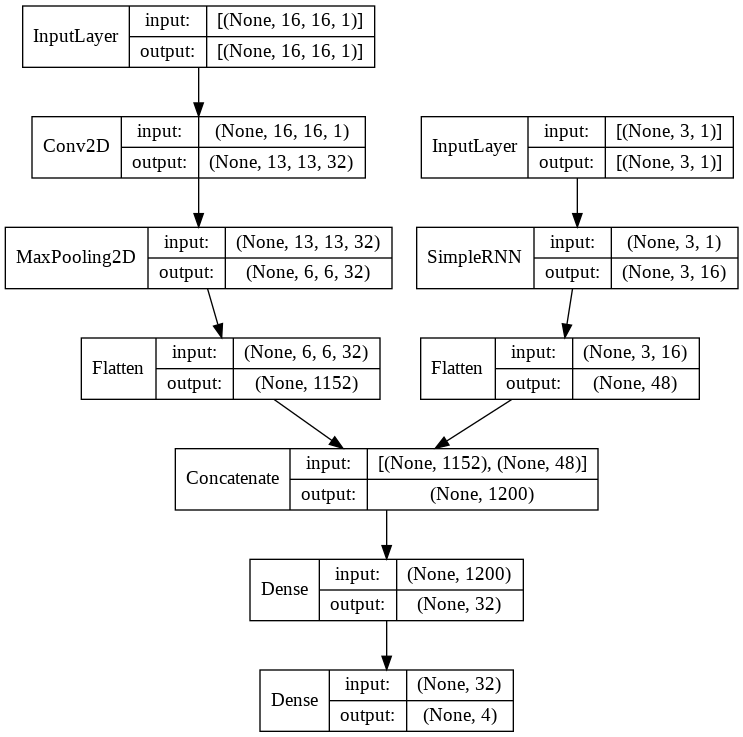

In [13]:
plot_model(model, show_shapes=True, show_layer_names=False)

In [14]:
train_datagen = image.ImageDataGenerator(
    rotation_range=10.,  # rotation angle
    rescale=1/255
    )

EPOCH = 10
BATCH = 2

history = model.fit_generator(
    generator=gen_flow_for_two_inputs(train_datagen, BATCH, x_image, x_text, y_train),
    steps_per_epoch=ceil(x_image.shape[0] / BATCH),
    epochs=EPOCH
    )

W0902 13:56:07.239842 139762302793600 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
2/2 [==============================] - 1s 583ms/step - loss: 1.4109 - acc: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 0s 8ms/step - loss: 1.3792 - acc: 0.0000e+00
Epoch 3/10
2/2 [==============================] - 0s 8ms/step - loss: 1.3545 - acc: 0.5000
Epoch 4/10
2/2 [==============================] - 0s 8ms/step - loss: 1.3346 - acc: 0.5000
Epoch 5/10
2/2 [==============================] - 0s 7ms/step - loss: 1.3176 - acc: 0.5000
Epoch 6/10
2/2 [==============================] - 0s 7ms/step - loss: 1.3002 - acc: 0.7500
Epoch 7/10
2/2 [==============================] - 0s 8ms/step - loss: 1.2834 - acc: 1.0000
Epoch 8/10
2/2 [==============================] - 0s 7ms/step - loss: 1.2712 - acc: 1.0000
Epoch 9/10
2/2 [==============================] - 0s 7ms/step - loss: 1.2581 - acc: 1.0000
Epoch 10/10
2/2 [==============================] - 0s 9ms/step - loss: 1.2415 - acc: 1.0000


In [0]:
test_datagen = image.ImageDataGenerator(rescale=1/255)

history = model.evaluate_generator(
    generator=gen_flow_for_two_inputs(test_datagen, BATCH, x_image, x_text, y_train),
    steps=ceil(x_image.shape[0] / BATCH)
    )

In [0]:
# shuffle should be false for prediction, since result goes with labels
y_pred = model.predict_generator(
    generator=gen_flow_for_two_inputs(test_datagen, BATCH, x_image, x_text, y_train, shuffle=False),
    steps=ceil(x_image.shape[0] / BATCH)
    )

In [0]:
y_train_np = np.argmax(y_train, axis=1)
y_pred_np = np.argmax(y_pred, axis=1)

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_train_np, y_pred_np))
print(confusion_matrix(y_train_np, y_pred_np))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
